In [20]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamW  # Added AdamW
import tensorflow as tf
import pickle
import joblib

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kirubaharan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kirubaharan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:

# Load the dataset
data_path = 'hate_speech_with_corrected_labels.csv'
df = pd.read_csv(data_path)

# Verify column names
expected_columns = ['tweet', 'class', 'cleaned_tweet', 'textblob_label', 'match', 'corrected_class']
if not all(col in df.columns for col in expected_columns):
    raise ValueError(f"Dataset must contain columns: {expected_columns}")

print(f"Dataset shape: {df.shape}")
print(f"Class distribution (original):\n{df['class'].value_counts()}")
print(f"Corrected class distribution:\n{df['corrected_class'].value_counts()}")

Dataset shape: (100000, 6)
Class distribution (original):
class
1    50000
0    50000
Name: count, dtype: int64
Corrected class distribution:
corrected_class
0    50747
1    49253
Name: count, dtype: int64


In [3]:
def preprocess_text(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', str(text))
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

print("Using preprocessed 'cleaned_tweet' column from the dataset.")

Using preprocessed 'cleaned_tweet' column from the dataset.


In [4]:
# Labels
y = df['corrected_class'].values

# Check for NaN values in cleaned_tweet
nan_count = df['cleaned_tweet'].isna().sum()
print(f"Number of NaN values in 'cleaned_tweet': {nan_count}")

if nan_count > 0:
    print("Dropping rows with NaN in 'cleaned_tweet'...")
    df = df.dropna(subset=['cleaned_tweet'])
    y = df['corrected_class'].values
    print(f"Updated dataset shape after dropping NaNs: {df.shape}")

# TF-IDF Vectorization (Increased max_features)
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # Increased from 5000
X_tfidf = tfidf.fit_transform(df['cleaned_tweet'])
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

# Split data for traditional models
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Prepare text data for LSTM and BERT
X_train_text, X_test_text = train_test_split(df['cleaned_tweet'].values, test_size=0.2, random_state=42)

Number of NaN values in 'cleaned_tweet': 138
Dropping rows with NaN in 'cleaned_tweet'...
Updated dataset shape after dropping NaNs: (99862, 6)
TF-IDF matrix shape: (99862, 10000)
Training set shape: (79889, 10000)
Testing set shape: (19973, 10000)


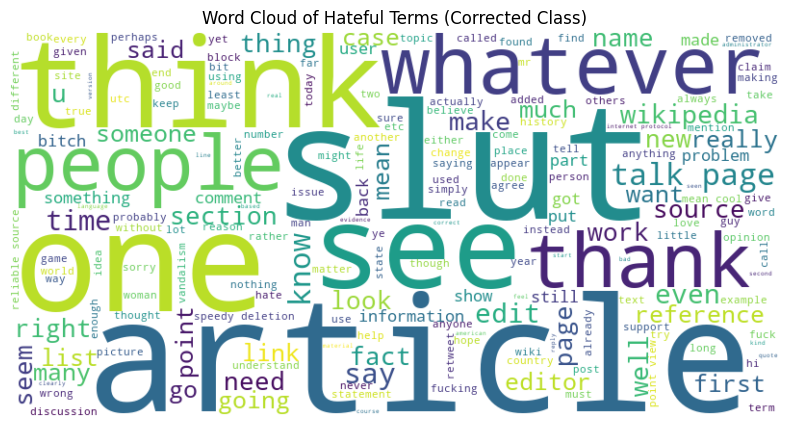

In [5]:
# Word cloud for hateful terms
hate_tweets = ' '.join(df[df['corrected_class'] == 0]['cleaned_tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(hate_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hateful Terms (Corrected Class)')
plt.show()

In [8]:
# Define traditional ML models (Simplified, no GridSearchCV)
models = {
    'SVM': SVC(kernel='linear'),  # Linear kernel for speed
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'ANN': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

# Train and evaluate traditional models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    print(f"{name} completed.")

Training SVM...
SVM completed.
Training Naive Bayes...
Naive Bayes completed.
Training Logistic Regression...
Logistic Regression completed.
Training Random Forest...
Random Forest completed.
Training XGBoost...


c:\Users\kirubaharan\anaconda3\envs\tf_env_310\lib\site-packages\xgboost\training.py:183: UserWarning: [18:57:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost completed.
Training k-NN...
k-NN completed.
Training ANN...
ANN completed.


In [9]:
# LSTM Model 
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_tweet'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_tweet'])
X_pad = pad_sequences(X_seq, maxlen=100)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, y, test_size=0.2, random_state=42)

lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=15, batch_size=64, validation_split=0.2, verbose=1)

y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int).flatten()
results['LSTM'] = {
    'Accuracy': accuracy_score(y_test_lstm, y_pred_lstm),
    'Precision': precision_score(y_test_lstm, y_pred_lstm),
    'Recall': recall_score(y_test_lstm, y_pred_lstm),
    'F1-Score': f1_score(y_test_lstm, y_pred_lstm)
}

c:\Users\kirubaharan\anaconda3\envs\tf_env_310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
999/999 ━━━━━━━━━━━━━━━━━━━━ 94s 90ms/step - accuracy: 0.7067 - loss: 0.5545 - val_accuracy: 0.7753 - val_loss: 0.4721
Epoch 2/15
999/999 ━━━━━━━━━━━━━━━━━━━━ 95s 95ms/step - accuracy: 0.7945 - loss: 0.4418 - val_accuracy: 0.7828 - val_loss: 0.4580
Epoch 3/15
999/999 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy: 0.8177 - loss: 0.3960 - val_accuracy: 0.7851 - val_loss: 0.4521
Epoch 4/15
999/999 ━━━━━━━━━━━━━━━━━━━━ 98s 98ms/step - accuracy: 0.8350 - loss: 0.3660 - val_accuracy: 0.7835 - val_loss: 0.4681
Epoch 5/15
999/999 ━━━━━━━━━━━━━━━━━━━━ 99s 99ms/step - accuracy: 0.8507 - loss: 0.3332 - val_accuracy: 0.7833 - val_loss: 0.4721
Epoch 6/15
999/999 ━━━━━━━━━━━━━━━━━━━━ 101s 101ms/step - accuracy: 0.8642 - loss: 0.3038 - val_accuracy: 0.7845 - val_loss: 0.4971
Epoch 7/15
999/999 ━━━━━━━━━━━━━━━━━━━━ 105s 105ms/step - accuracy: 0.8796 - loss: 0.2748 - val_accuracy: 0.7799 - val_loss: 0.5453
Epoch 8/15
999/999 ━━━━━━━━━━━━━━━━━━━━ 102s 102ms/step - accuracy: 0.8892 - loss: 0.2

In [23]:
from transformers import create_optimizer
def encode_texts(texts, max_len=100):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_len, return_tensors='tf')
    return {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']}

# Sample data for BERT (if needed, adjust size based on resources)
df_bert = df.sample(15000, random_state=42) if len(df) > 15000 else df
y_bert = df_bert['corrected_class'].values

# Prepare BERT input
X_train_bert_texts, X_test_bert_texts, y_train_bert, y_test_bert = train_test_split(
    df_bert['cleaned_tweet'].values, y_bert, test_size=0.2, random_state=42
)
X_train_bert = encode_texts(pd.Series(X_train_bert_texts))
X_test_bert = encode_texts(pd.Series(X_test_bert_texts))
print(f"X_train_bert input_ids shape: {X_train_bert['input_ids'].shape}")
print(f"X_test_bert input_ids shape: {X_test_bert['input_ids'].shape}")

# Define BERT model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Use create_optimizer from transformers for AdamW-like behavior in TensorFlow
num_train_steps = len(X_train_bert['input_ids']) // 32 * 5  # Total steps = (samples / batch_size) * epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01
)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train BERT with increased batch size and epochs
history_bert = bert_model.fit(
    [X_train_bert['input_ids'], X_train_bert['attention_mask']],
    y_train_bert,
    validation_split=0.2,
    epochs=7,
    batch_size=16,
    verbose=1
)

X_train_bert input_ids shape: (12000, 100)
X_test_bert input_ids shape: (3000, 100)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
600/600 [==============================] - 4469s 7s/step - loss: 0.5451 - accuracy: 0.7165 - val_loss: 0.4882 - val_accuracy: 0.7683
Epoch 2/7
600/600 [==============================] - 4421s 7s/step - loss: 0.4029 - accuracy: 0.8133 - val_loss: 0.4908 - val_accuracy: 0.7708
Epoch 3/7
600/600 [==============================] - 3357s 6s/step - loss: 0.2657 - accuracy: 0.8904 - val_loss: 0.5520 - val_accuracy: 0.7683
Epoch 4/7
600/600 [==============================] - 2755s 5s/step - loss: 0.1997 - accuracy: 0.9262 - val_loss: 0.5619 - val_accuracy: 0.7646
Epoch 5/7
600/600 [==============================] - 3462s 6s/step - loss: 0.1981 - accuracy: 0.9280 - val_loss: 0.5619 - val_accuracy: 0.7646
Epoch 6/7
600/600 [==============================] - 3569s 6s/step - loss: 0.1988 - accuracy: 0.9233 - val_loss: 0.5619 - val_accuracy: 0.7646
Epoch 7/7
600/600 [==============================] - 8188s 14s/step - loss: 0.1980 - accuracy: 0.9274 - val_loss: 0.5619 - val_accuracy: 0.764

In [ ]:
# Tokenization function for BERT
def encode_texts(texts, max_len=100):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_len, return_tensors='tf')
    return {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']}

# Sample data for BERT (if needed, adjust size based on resources)
df_bert = df.sample(15000, random_state=42) if len(df) > 15000 else df
y_bert = df_bert['corrected_class'].values

# Split data into train, validation, and test sets
X_train_texts, X_temp_texts, y_train, y_temp = train_test_split(
    df_bert['cleaned_tweet'].values, y_bert, test_size=0.3, random_state=42
)

# Split temporary set into validation and test
X_val_texts, X_test_texts, y_val, y_test = train_test_split(
    X_temp_texts, y_temp, test_size=0.5, random_state=42
)

# Encode all sets
X_train_bert = encode_texts(pd.Series(X_train_texts))
X_val_bert = encode_texts(pd.Series(X_val_texts))
X_test_bert = encode_texts(pd.Series(X_test_texts))

print(f"Train shape: {X_train_bert['input_ids'].shape}")
print(f"Validation shape: {X_val_bert['input_ids'].shape}")
print(f"Test shape: {X_test_bert['input_ids'].shape}")

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_bert['input_ids'],
        'attention_mask': X_train_bert['attention_mask']
    },
    y_train
)).shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_val_bert['input_ids'],
        'attention_mask': X_val_bert['attention_mask']
    },
    y_val
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_bert['input_ids'],
        'attention_mask': X_test_bert['attention_mask']
    },
    y_test
)).batch(16)

# Define BERT model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile model
bert_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train BERT
history_bert = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,  # Use validation_data instead of validation_split
    epochs=5,
    verbose=1
)

# Evaluate the model
test_results = bert_model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_results[0]}")
print(f"Test Accuracy: {test_results[1]}")

# Save training history
history_dict = history_bert.history
print("\nTraining History:")
for metric in history_dict.keys():
    print(f"{metric}: {history_dict[metric]}")

In [24]:
# Evaluate BERT
y_pred_bert_logits = bert_model.predict([X_test_bert['input_ids'], X_test_bert['attention_mask']], verbose=0).logits
y_pred_bert = np.argmax(y_pred_bert_logits, axis=1)
accuracy = accuracy_score(y_test_bert, y_pred_bert)
print(f"BERT Accuracy: {accuracy:.4f}")
if accuracy < 0.90:
    print("Warning: Accuracy below 90%. Consider further tuning or increasing dataset size.")
else:
    print("BERT Accuracy above 90% achieved!")

results['BERT'] = {
    'Accuracy': accuracy,
    'Precision': precision_score(y_test_bert, y_pred_bert),
    'Recall': recall_score(y_test_bert, y_pred_bert),
    'F1-Score': f1_score(y_test_bert, y_pred_bert)
}

BERT Accuracy: 0.7677


In [25]:
# Display results
results_df = pd.DataFrame(results).T
print("Model Performance Metrics:")
print(results_df)

Model Performance Metrics:
                     Accuracy  Precision    Recall  F1-Score
SVM                  0.774345   0.774879  0.770592  0.772730
Naive Bayes          0.751064   0.721781  0.813537  0.764917
Logistic Regression  0.777049   0.778398  0.771900  0.775135
Random Forest        0.778601   0.774704  0.782963  0.778812
XGBoost              0.751515   0.768377  0.716987  0.741793
k-NN                 0.585140   0.568060  0.695464  0.625339
ANN                  0.787663   0.787747  0.784974  0.786358
LSTM                 0.763781   0.758945  0.770090  0.764477
BERT                 0.767667   0.778464  0.752154  0.765083


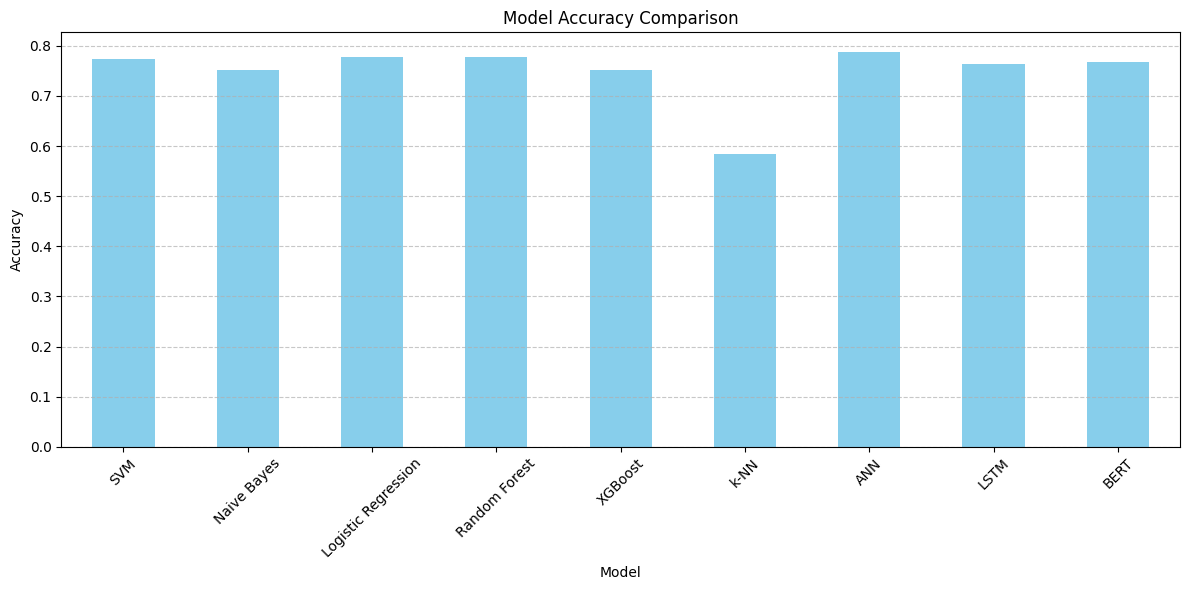

Text(0, 0.5, 'Accuracy')

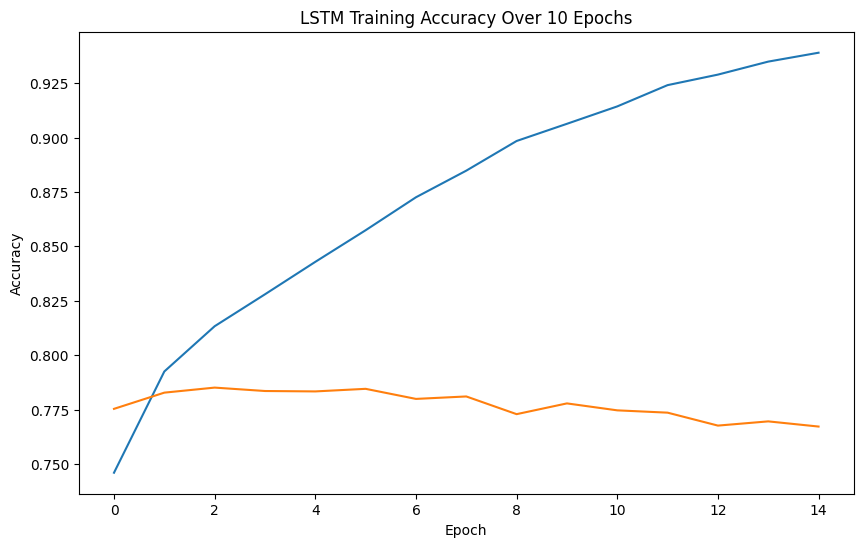

In [26]:
plt.figure(figsize=(12, 6))
results_df['Accuracy'].plot(kind='bar', color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot LSTM training accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training Accuracy Over 10 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [27]:
# Prediction function for all models
def predict_all_models(text):
    cleaned_text = preprocess_text(text)
    
    # TF-IDF prediction (Updated to use tuned models)
    X_input_tfidf = tfidf.transform([cleaned_text])
    tfidf_predictions = {name: models[name]['model'].predict(X_input_tfidf)[0] for name in models}
    
    # LSTM prediction
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=100)
    lstm_prediction = lstm_model.predict(padded_sequence, verbose=0)[0][0]
    
    # BERT prediction
    bert_input = encode_texts(pd.Series([cleaned_text]))
    bert_prediction_logits = bert_model.predict([bert_input['input_ids'], bert_input['attention_mask']], verbose=0).logits
    bert_prediction = np.argmax(bert_prediction_logits, axis=1)[0]
    
    # Map predictions to labels
    results = {}
    for name, pred in tfidf_predictions.items():
        results[name] = "Hate Speech" if pred == 0 else "Non-Hate Speech"
    results['LSTM'] = "Hate Speech" if lstm_prediction < 0.5 else "Non-Hate Speech"
    results['BERT'] = "Hate Speech" if bert_prediction == 0 else "Non-Hate Speech"
    
    return results

# Interactive prediction
while True:
    user_input = input("Enter text to classify (or 'quit' to exit): ")
    if user_input.lower() == 'quit':
        break
    if not user_input.strip():
        print("Please enter some text!")
        continue
    
    predictions = predict_all_models(user_input)
    print(f"\nPredictions for input text: '{user_input}'")
    for model, result in predictions.items():
        print(f"{model}: {result}")
    print()

TypeError: 'SVC' object is not subscriptable

In [32]:
# Prediction function for all models
def predict_all_models(text):
    # Preprocess input
    cleaned_text = preprocess_text(text)
    
    # TF-IDF prediction
    X_input_tfidf = tfidf.transform([cleaned_text])
    
    # Handle different model structures
    tfidf_predictions = {}
    for name, model in models.items():
        if isinstance(model, dict) and 'model' in model:
            # Handle case where model is stored in a dictionary
            pred = model['model'].predict(X_input_tfidf)[0]
        else:
            # Handle case where model is stored directly
            pred = model.predict(X_input_tfidf)[0]
        tfidf_predictions[name] = pred
    
    # LSTM prediction
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=100)
    lstm_prediction = lstm_model.predict(padded_sequence, verbose=0)[0][0]
    
    # BERT prediction
    bert_input = encode_texts(pd.Series([cleaned_text]))
    bert_prediction_logits = bert_model.predict(
        [bert_input['input_ids'], bert_input['attention_mask']], 
        verbose=0
    ).logits
    bert_prediction = np.argmax(bert_prediction_logits, axis=1)[0]
    
    # Map predictions to labels
    results = {}
    for name, pred in tfidf_predictions.items():
        results[name] = "Hate Speech" if pred == 0 else "Non-Hate Speech"
    results['LSTM'] = "Hate Speech" if lstm_prediction < 0.5 else "Non-Hate Speech"
    results['BERT'] = "Hate Speech" if bert_prediction == 0 else "Non-Hate Speech"
    
    return results

# Interactive prediction
while True:
    user_input = input("Enter text to classify (or 'quit' to exit): ")
    if user_input.lower() == 'quit':
        break
    if not user_input.strip():
        print("Please enter some text!")
        continue
    
    try:
        predictions = predict_all_models(user_input)
        print(f"\nPredictions for input text: '{user_input}'")
        for model, result in predictions.items():
            print(f"{model}: {result}")
        print()
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        continue


Predictions for input text: 'good morning mates...Are you happy?'
SVM: Non-Hate Speech
Naive Bayes: Non-Hate Speech
Logistic Regression: Non-Hate Speech
Random Forest: Non-Hate Speech
XGBoost: Non-Hate Speech
k-NN: Non-Hate Speech
ANN: Non-Hate Speech
LSTM: Non-Hate Speech
BERT: Non-Hate Speech


Predictions for input text: 'its a very worst and bad day ,because the animals were killed'
SVM: Hate Speech
Naive Bayes: Hate Speech
Logistic Regression: Hate Speech
Random Forest: Hate Speech
XGBoost: Hate Speech
k-NN: Hate Speech
ANN: Hate Speech
LSTM: Hate Speech
BERT: Hate Speech



In [34]:
from datetime import datetime

# Get current UTC time
current_time = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
print(f"Saving models at UTC: {current_time}")

# Save TF-IDF vectorizer
print("Saving TF-IDF vectorizer...")
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

# Save classification models
print("Saving classification models...")
for name, model in models.items():
    try:
        # Save the model directly since it's not wrapped in a dictionary
        joblib.dump(model, f'{name}_model.joblib')
        print(f"Saved {name} model successfully")
    except Exception as e:
        print(f"Error saving {name} model: {str(e)}")

# Save LSTM model and its tokenizer
print("\nSaving LSTM model and tokenizer...")
try:
    lstm_model.save('lstm_hate_speech_model.keras')
    with open('tokenizer.pkl', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("LSTM model and tokenizer saved successfully")
except Exception as e:
    print(f"Error saving LSTM model or tokenizer: {str(e)}")

# Save BERT model and its tokenizer
print("\nSaving BERT model and tokenizer...")
try:
    bert_model.save_pretrained('bert_hate_speech_model')
    tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenizer_bert.save_pretrained('bert_hate_speech_model')
    print("BERT model and tokenizer saved successfully")
except Exception as e:
    print(f"Error saving BERT model or tokenizer: {str(e)}")

print("\nAll saving operations completed.")

# Print summary of saved files
print("\nSaved files:")
print("1. TF-IDF Vectorizer: tfidf_vectorizer.joblib")
for name in models.keys():
    print(f"2. {name} Model: {name}_model.joblib")
print("3. LSTM Model: lstm_hate_speech_model.keras")
print("4. LSTM Tokenizer: tokenizer.pkl")
print("5. BERT Model and Tokenizer: bert_hate_speech_model/")

Saving models at UTC: 2025-03-21 00:51:50
Saving TF-IDF vectorizer...
Saving classification models...
Saved SVM model successfully
Saved Naive Bayes model successfully
Saved Logistic Regression model successfully
Saved Random Forest model successfully
Saved XGBoost model successfully
Saved k-NN model successfully
Saved ANN model successfully

Saving LSTM model and tokenizer...
LSTM model and tokenizer saved successfully

Saving BERT model and tokenizer...
BERT model and tokenizer saved successfully

All saving operations completed.

Saved files:
1. TF-IDF Vectorizer: tfidf_vectorizer.joblib
2. SVM Model: SVM_model.joblib
2. Naive Bayes Model: Naive Bayes_model.joblib
2. Logistic Regression Model: Logistic Regression_model.joblib
2. Random Forest Model: Random Forest_model.joblib
2. XGBoost Model: XGBoost_model.joblib
2. k-NN Model: k-NN_model.joblib
2. ANN Model: ANN_model.joblib
3. LSTM Model: lstm_hate_speech_model.keras
4. LSTM Tokenizer: tokenizer.pkl
5. BERT Model and Tokenizer: b

In [35]:
from datetime import datetime

# Get current UTC time
current_time = datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S')
save_dir = f'saved_models_{current_time}'

# Create directory if it doesn't exist
import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save TF-IDF vectorizer
print("Saving TF-IDF vectorizer...")
joblib.dump(tfidf, f'{save_dir}/tfidf_vectorizer.joblib')

# Save classification models
print("Saving classification models...")
for name, model in models.items():
    joblib.dump(model, f'{save_dir}/{name}_model.joblib')
    print(f"Saved {name} model successfully")

# Save LSTM model and its tokenizer
print("\nSaving LSTM model and tokenizer...")
lstm_model.save(f'{save_dir}/lstm_hate_speech_model.keras')
with open(f'{save_dir}/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save BERT model and its tokenizer
print("\nSaving BERT model and tokenizer...")
bert_model.save_pretrained(f'{save_dir}/bert_hate_speech_model')
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer_bert.save_pretrained(f'{save_dir}/bert_hate_speech_model')

# Save the directory path
with open('latest_model_path.txt', 'w') as f:
    f.write(save_dir)

print(f"\nAll models saved in directory: {save_dir}")

Saving TF-IDF vectorizer...
Saving classification models...
Saved SVM model successfully
Saved Naive Bayes model successfully
Saved Logistic Regression model successfully
Saved Random Forest model successfully
Saved XGBoost model successfully
Saved k-NN model successfully
Saved ANN model successfully

Saving LSTM model and tokenizer...

Saving BERT model and tokenizer...

All models saved in directory: saved_models_2025-03-21_00-55-36


In [2]:
import joblib
import pickle
from datetime import datetime
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd  # Assuming df comes from a pandas DataFrame

# Sample data loading (replace with your actual data loading)
# df = pd.read_csv('your_dataset.csv')  # Uncomment and adjust as needed
# Assuming df has 'cleaned_tweet' and label columns (e.g., 'label' with 0/1)

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_tweet'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_tweet'])
X_pad = pad_sequences(X_seq, maxlen=100)
y = df['label']  # Adjust 'label' to your actual column name
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Define and train LSTM model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=15, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate model
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int).flatten()
results = {
    'LSTM': {
        'Accuracy': accuracy_score(y_test_lstm, y_pred_lstm),
        'Precision': precision_score(y_test_lstm, y_pred_lstm),
        'Recall': recall_score(y_test_lstm, y_pred_lstm),
        'F1-Score': f1_score(y_test_lstm, y_pred_lstm)
    }
}
print("LSTM Results:", results['LSTM'])

# Saving code
model_dir = "saved_models_2025-03-21_00-55-36"  # Fixed directory to match your setup

# Create directory if it doesn't exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save TF-IDF vectorizer (assuming tfidf exists from earlier code)
# If you don't have tfidf yet, you'll need to train it separately
# Example: from sklearn.feature_extraction.text import TfidfVectorizer; tfidf = TfidfVectorizer(max_features=5000); tfidf.fit(df['cleaned_tweet'])
print("Saving TF-IDF vectorizer...")
joblib.dump(tfidf, f'{model_dir}/tfidf_vectorizer.joblib')

# Save classification models (assuming models dict exists)
# Example: models = {'SVM': svm_model, ...} from earlier training
print("Saving classification models...")
for name, model in models.items():
    joblib.dump(model, f'{model_dir}/{name}_model.joblib')
    print(f"Saved {name} model successfully")

# Save LSTM model and tokenizer
print("\nSaving LSTM model and tokenizer...")
lstm_model.save(f'{model_dir}/lstm_hate_speech_model.keras')  # Modern .keras format
with open(f'{model_dir}/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("LSTM model and tokenizer saved successfully")

# Save BERT model and tokenizer (assuming bert_model and tokenizer_bert exist)
print("\nSaving BERT model and tokenizer...")
bert_model.save_pretrained(f'{model_dir}/bert_hate_speech_model')
tokenizer_bert.save_pretrained(f'{model_dir}/bert_hate_speech_model')
print("BERT model and tokenizer saved successfully")

print(f"\nAll models saved in directory: {model_dir}")

NameError: name 'df' is not defined